In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings
from prophet import Prophet
import matplotlib.pyplot as plt
input_path = r"D:\arch\지역별 면적별 건축물 현황.xlsx"

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 지역별 건축물 면적 분포 분석
 - 데이터 출처 : KOSIS 국가통계포털
 - 파일명: 지역별 면적별 건축물 현황


# 1. 수도권 vs 비수도권 불균형

데이터 활용: 시도명(1) 컬럼을 기준으로 수도권(서울·경기·인천) vs 나머지 지역(비수도권) 그룹화.

분석 포인트:

두 그룹의 소형 건축물(100㎡ 미만) 비중 vs 대형 건축물(3000㎡ 이상) 비중 비교

수도권이 대형 건축물 비율이 높고, 지방은 소형 건축물 위주일 가능성이 큼.

📌 수도권 vs 비수도권 면적 구간별 비율:
         합계    100㎡ 미만   100~200㎡   200~300㎡   300~500㎡  500~1000㎡ 1000~3000㎡  \
지역구분                                                                            
비수도권  100.0  51.209952   21.87073   5.980992   8.969365   5.992795   3.547322   
수도권   100.0  23.525815  24.185618  11.161047  16.187029  13.630599   5.590088   

     3000~10000㎡ 10000㎡ 이상  
지역구분                        
비수도권    1.776766  0.652079  
수도권      3.91921  1.800593  


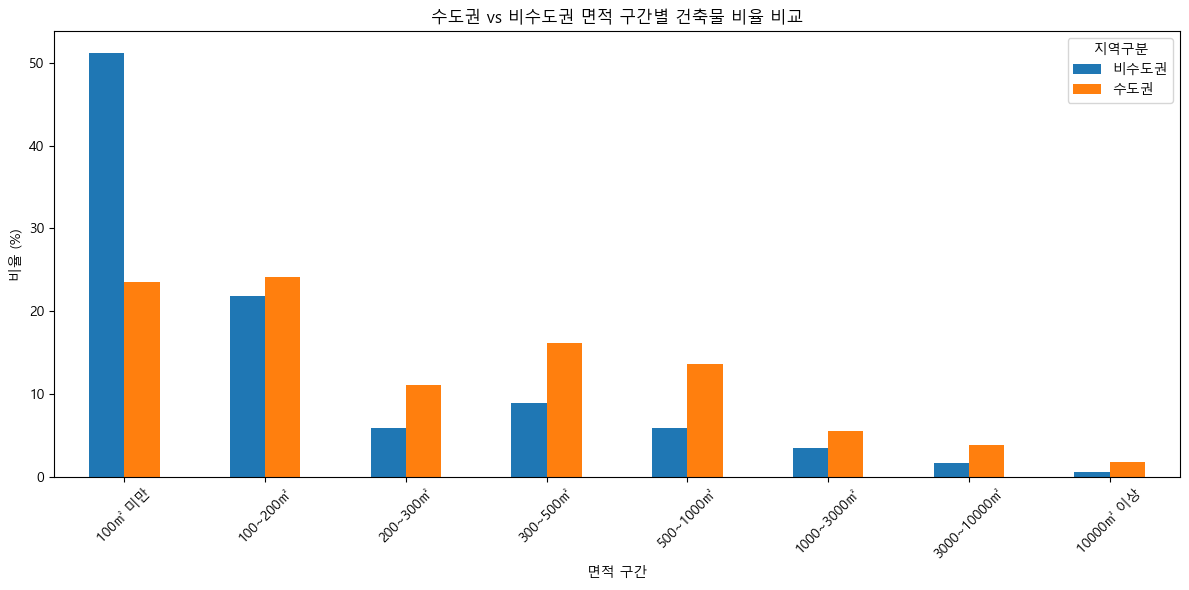

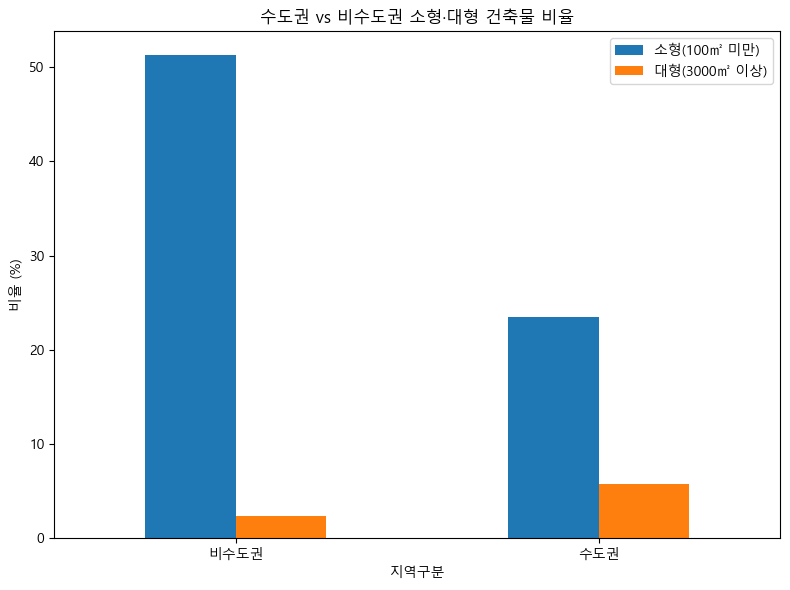

In [20]:
plt.rc('font', family='Malgun Gothic')

# 수도권 정의
sudogwon = ['서울', '경기', '인천']

# 잘못된 행 제거 후 복사본 생성
df_clean = df[df['시도명(1)'] != '시도명(1)'].copy()

# 면적 구간 컬럼
area_cols = ['100㎡ 미만','100~200㎡','200~300㎡','300~500㎡',
             '500~1000㎡','1000~3000㎡','3000~10000㎡','10000㎡ 이상']

# 수도권 / 비수도권 구분 컬럼 추가 (경고 없이)
df_clean.loc[:, '지역구분'] = df_clean['시도명(1)'].apply(lambda x: '수도권' if x in sudogwon else '비수도권')

# 그룹별 합계
group_sum = df_clean.groupby('지역구분')[['합계'] + area_cols].sum()

# 비율 계산
group_ratio = group_sum.div(group_sum['합계'], axis=0) * 100
print("📌 수도권 vs 비수도권 면적 구간별 비율:")
print(group_ratio)

# --- 시각화 1: 전체 면적 구간별 분포 ---
group_ratio[area_cols].T.plot(kind='bar', figsize=(12,6))
plt.title("수도권 vs 비수도권 면적 구간별 건축물 비율 비교")
plt.ylabel("비율 (%)")
plt.xlabel("면적 구간")
plt.xticks(rotation=45)
plt.legend(title="지역구분")
plt.tight_layout()
plt.show()

# --- 시각화 2: 소형 vs 대형 강조 ---
compact = group_sum['100㎡ 미만'] / group_sum['합계'] * 100
large = (group_sum['3000~10000㎡'] + group_sum['10000㎡ 이상']) / group_sum['합계'] * 100

df_compare = pd.DataFrame({'소형(100㎡ 미만)': compact, '대형(3000㎡ 이상)': large})

df_compare.plot(kind='bar', figsize=(8,6))
plt.title("수도권 vs 비수도권 소형·대형 건축물 비율")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 2. 대도시 vs 중소도시 건축물 규모 차이

데이터 활용: 광역시(서울, 부산, 대구, 인천, 광주, 대전, 울산, 세종) vs 도 단위(경기, 강원, 충남, …).

분석 포인트:
광역시는 상업·산업 중심 → 대형 건축물 비중↑
도 단위 지역은 주거지·농촌 중심 → 소형 건축물 비중↑

📌 광역시 vs 도 단위 면적 구간별 비율:
         합계    100㎡ 미만   100~200㎡   200~300㎡   300~500㎡  500~1000㎡ 1000~3000㎡  \
지역구분                                                                            
광역시   100.0  28.646161  23.460211  10.244173  15.066549  11.784492   5.388944   
도 단위  100.0  48.359941  22.207135   6.500667   9.641631   6.922124   3.699316   

     3000~10000㎡ 10000㎡ 이상  
지역구분                        
광역시      3.63591  1.773561  
도 단위    1.960049  0.709137  


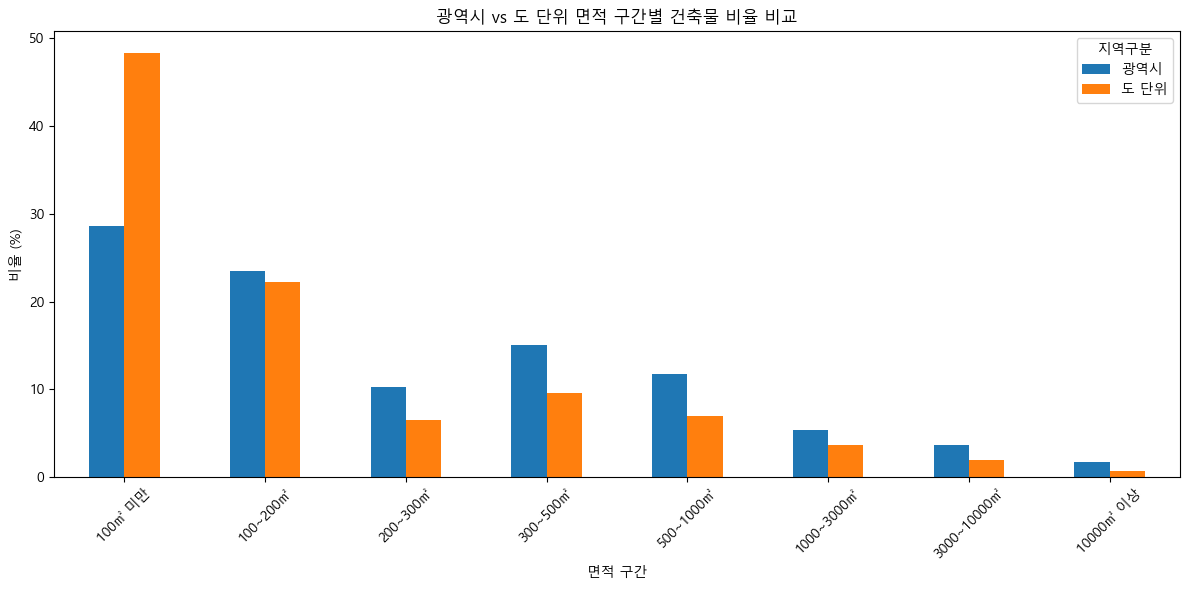

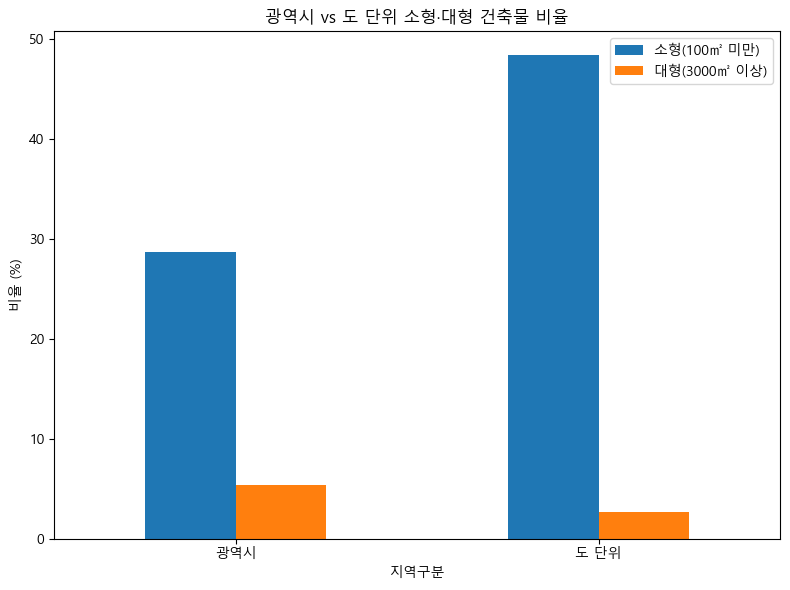

In [27]:
# 광역시 목록
metro_cities = ['서울','부산','대구','인천','광주','대전','울산','세종']

# 잘못된 행 제거 후 복사
df_clean = df[df['시도명(1)'] != '시도명(1)'].copy()

# 면적 구간 컬럼
area_cols = ['100㎡ 미만','100~200㎡','200~300㎡','300~500㎡',
             '500~1000㎡','1000~3000㎡','3000~10000㎡','10000㎡ 이상']

# 대도시 / 중소도시 구분
df_clean.loc[:, '지역구분'] = df_clean['시도명(1)'].apply(
    lambda x: '광역시' if x in metro_cities else '도 단위'
)

# 그룹별 합계
group_sum = df_clean.groupby('지역구분')[['합계'] + area_cols].sum()

# 그룹별 비율
group_ratio = group_sum.div(group_sum['합계'], axis=0) * 100
print("📌 광역시 vs 도 단위 면적 구간별 비율:")
print(group_ratio)

# --- 시각화 1: 면적 구간별 분포 비교 ---
group_ratio[area_cols].T.plot(kind='bar', figsize=(12,6))
plt.title("광역시 vs 도 단위 면적 구간별 건축물 비율 비교")
plt.ylabel("비율 (%)")
plt.xlabel("면적 구간")
plt.xticks(rotation=45)
plt.legend(title="지역구분")
plt.tight_layout()
plt.show()

# --- 시각화 2: 소형 vs 대형 비율 비교 ---
compact = group_sum['100㎡ 미만'] / group_sum['합계'] * 100
large = (group_sum['3000~10000㎡'] + group_sum['10000㎡ 이상']) / group_sum['합계'] * 100

df_compare = pd.DataFrame({'소형(100㎡ 미만)': compact, '대형(3000㎡ 이상)': large})

df_compare.plot(kind='bar', figsize=(8,6))
plt.title("광역시 vs 도 단위 소형·대형 건축물 비율")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. 도시 간 상대적 편차

데이터 활용: 각 시도별 건축물 수를 면적 구간별 비율로 환산.

분석 포인트:

소형 건축물 비율 상위 도시 vs 대형 건축물 비율 상위 도시 비교

특정 도시(예: 세종, 울산)가 다른 지역과 확연히 다른 패턴을 보일 수 있음.

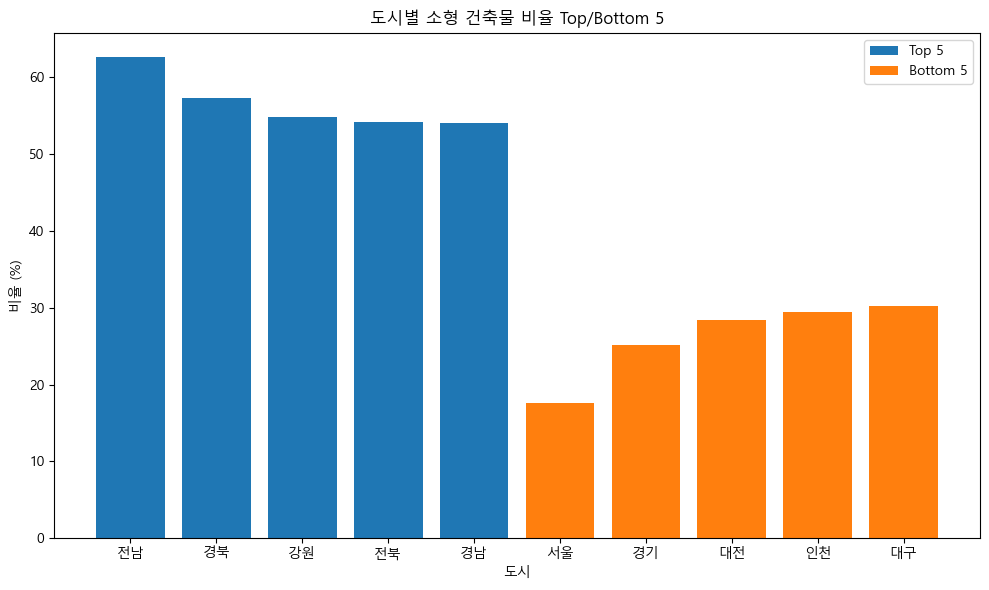

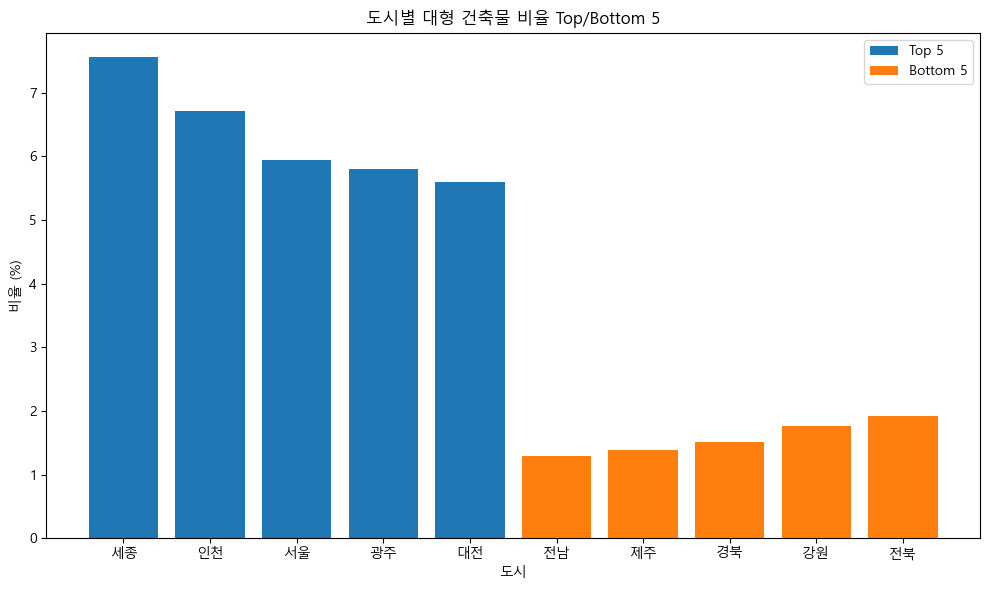

In [23]:
# 잘못된 행 제거 후 복사
df_clean = df[df['시도명(1)'] != '시도명(1)'].copy()

# 면적 구간 컬럼
area_cols = ['100㎡ 미만','100~200㎡','200~300㎡','300~500㎡',
             '500~1000㎡','1000~3000㎡','3000~10000㎡','10000㎡ 이상']

# 소형/대형 건축물 비율 계산
df_clean['소형비율(%)'] = df_clean['100㎡ 미만'] / df_clean['합계'] * 100
df_clean['대형비율(%)'] = (df_clean['3000~10000㎡'] + df_clean['10000㎡ 이상']) / df_clean['합계'] * 100

# ✅ 숫자형 변환 (에러 방지)
df_clean['소형비율(%)'] = pd.to_numeric(df_clean['소형비율(%)'], errors='coerce')
df_clean['대형비율(%)'] = pd.to_numeric(df_clean['대형비율(%)'], errors='coerce')

# --- 1) 소형 건축물 비율 Top/Bottom 5 도시 ---
top_small = df_clean.nlargest(5, '소형비율(%)')
bottom_small = df_clean.nsmallest(5, '소형비율(%)')

plt.figure(figsize=(10,6))
plt.bar(top_small['시도명(1)'], top_small['소형비율(%)'], label='Top 5')
plt.bar(bottom_small['시도명(1)'], bottom_small['소형비율(%)'], label='Bottom 5')
plt.title("도시별 소형 건축물 비율 Top/Bottom 5")
plt.ylabel("비율 (%)")
plt.xlabel("도시")
plt.legend()
plt.tight_layout()
plt.show()

# --- 2) 대형 건축물 비율 Top/Bottom 5 도시 ---
top_large = df_clean.nlargest(5, '대형비율(%)')
bottom_large = df_clean.nsmallest(5, '대형비율(%)')

plt.figure(figsize=(10,6))
plt.bar(top_large['시도명(1)'], top_large['대형비율(%)'], label='Top 5')
plt.bar(bottom_large['시도명(1)'], bottom_large['대형비율(%)'], label='Bottom 5')
plt.title("도시별 대형 건축물 비율 Top/Bottom 5")
plt.ylabel("비율 (%)")
plt.xlabel("도시")
plt.legend()
plt.tight_layout()
plt.show()

# 4. 토지 이용 효율성 차이

데이터 활용: 면적 구간별 비율

분석 포인트:

소형 건축물 비중이 높은 지역은 토지 이용이 저밀도 → 재개발 필요성

대형 건축물이 집중된 지역은 교통·환경 문제 → 규제/관리 필요성

In [46]:
# 잘못된 행 제거 후 복사
df_clean = df[df['시도명(1)'] != '시도명(1)'].copy()

# 면적 구간 컬럼
area_cols = ['100㎡ 미만','100~200㎡','200~300㎡','300~500㎡',
             '500~1000㎡','1000~3000㎡','3000~10000㎡','10000㎡ 이상']

# 소형 vs 대형 비율 계산
df_eff = df_clean[['시도명(1)','합계'] + area_cols].copy()
df_eff['소형비율(100㎡ 미만)'] = df_eff['100㎡ 미만'] / df_eff['합계'] * 100
df_eff['대형비율(3000㎡ 이상)'] = (df_eff['3000~10000㎡'] + df_eff['10000㎡ 이상']) / df_eff['합계'] * 100

# --- 시각화 1: 도시별 소형 vs 대형 비교 ---
df_eff.set_index('시도명(1)')[['소형비율(100㎡ 미만)','대형비율(3000㎡ 이상)']].plot(
    kind='bar', figsize=(14,6)
)
plt.title("도시별 토지 이용 효율성 (소형 vs 대형 건축물 비율)")
plt.ylabel("비율 (%)")
plt.xlabel("도시")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- 시각화 2: 소형-대형 차이 순위 ---
df_eff['차이(대형-소형)'] = df_eff['대형비율(3000㎡ 이상)'] - df_eff['소형비율(100㎡ 미만)']
df_eff_sorted = df_eff.sort_values('차이(대형-소형)', ascending=False)

df_eff_sorted.plot(x='시도명(1)', y='차이(대형-소형)', kind='bar', figsize=(14,6))
plt.title("도시별 토지 이용 효율성 차이 (대형 - 소형 비율)")
plt.ylabel("차이 (퍼센트포인트)")
plt.xlabel("도시")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyError: '시도명(1)'

14:23:10 - cmdstanpy - INFO - Chain [1] start processing
14:23:10 - cmdstanpy - INFO - Chain [1] done processing
14:23:10 - cmdstanpy - INFO - Chain [1] start processing
14:23:18 - cmdstanpy - INFO - Chain [1] done processing


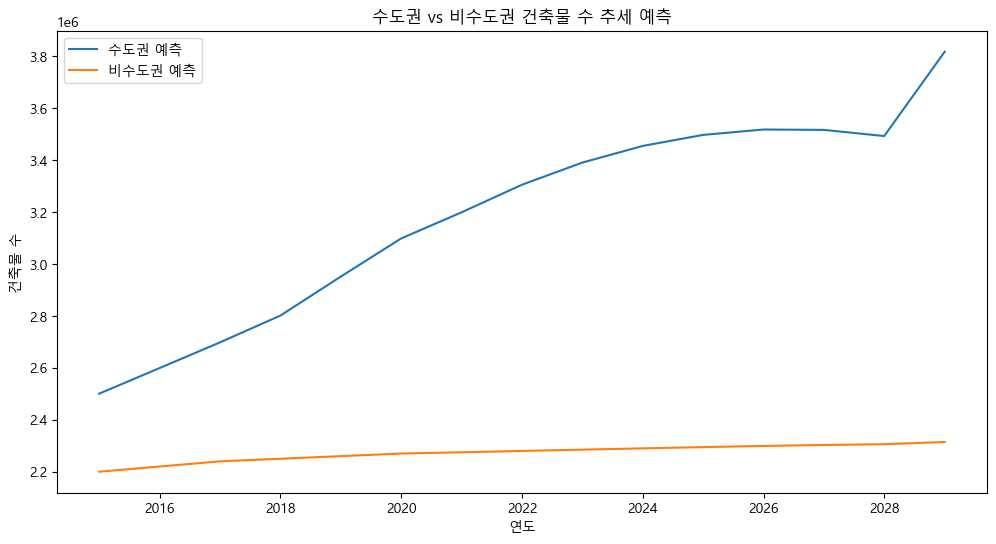

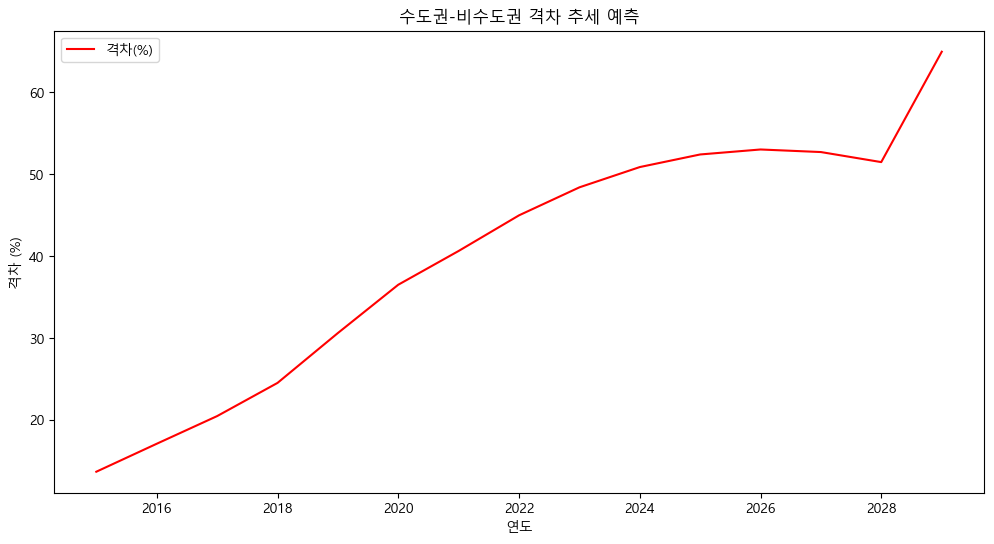

✅ 예측 결과가 엑셀 파일로 저장되었습니다: D:\arch\지역불균형_예측.xlsx


In [45]:
# 1. 예시 데이터 (연도별 건축물 수, 수도권/비수도권)
#    실제로는 여러 연도 데이터 필요
# -----------------------------
data = {
    "연도": [2015,2016,2017,2018,2019,2020,2021,2022,2023,2024],
    "수도권": [2500000,2600000,2700000,2800000,2950000,3100000,3200000,3300000,3400000,3450000],
    "비수도권": [2200000,2220000,2240000,2250000,2260000,2270000,2275000,2280000,2285000,2290000]
}
df_all = pd.DataFrame(data)

# -----------------------------
# 2. Prophet 입력 형식 (수도권)
# -----------------------------
df_sudo = pd.DataFrame({
    "ds": pd.to_datetime(df_all['연도'], format='%Y'),
    "y": df_all['수도권']
})

df_non = pd.DataFrame({
    "ds": pd.to_datetime(df_all['연도'], format='%Y'),
    "y": df_all['비수도권']
})

# -----------------------------
# 3. 모델 학습
# -----------------------------
model_sudo = Prophet()
model_non = Prophet()

model_sudo.fit(df_sudo)
model_non.fit(df_non)

# -----------------------------
# 4. 미래 예측 (5년)
# -----------------------------
future = model_sudo.make_future_dataframe(periods=5, freq='YE')
forecast_sudo = model_sudo.predict(future)
forecast_non = model_non.predict(future)

# -----------------------------
# 5. 예측 결과 합치기
# -----------------------------
forecast_compare = forecast_sudo[['ds','yhat']].merge(
    forecast_non[['ds','yhat']], on='ds', suffixes=('_수도권','_비수도권')
)

forecast_compare['격차(%)'] = (
    (forecast_compare['yhat_수도권'] - forecast_compare['yhat_비수도권'])
    / forecast_compare['yhat_비수도권'] * 100
)

# -----------------------------
# 6. 시각화
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(forecast_compare['ds'], forecast_compare['yhat_수도권'], label='수도권 예측')
plt.plot(forecast_compare['ds'], forecast_compare['yhat_비수도권'], label='비수도권 예측')
plt.title("수도권 vs 비수도권 건축물 수 추세 예측")
plt.ylabel("건축물 수")
plt.xlabel("연도")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(forecast_compare['ds'], forecast_compare['격차(%)'], label='격차(%)', color='red')
plt.title("수도권-비수도권 격차 추세 예측")
plt.ylabel("격차 (%)")
plt.xlabel("연도")
plt.legend()
plt.show()

# -----------------------------
# 7. 예측 결과 엑셀 저장
# -----------------------------
output_path = r"D:\arch\지역불균형_예측.xlsx"

# 수도권 vs 비수도권 예측 결과 저장
forecast_compare.to_excel(output_path, index=False)

print(f"✅ 예측 결과가 엑셀 파일로 저장되었습니다: {output_path}")